In [70]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import arch 
import matplotlib.pyplot as plt
import random
import requests
from bs4 import BeautifulSoup
import warnings


In [71]:
#######Importing the SP500 Tickers
period="1y"
SP500names = 'https://stockanalysis.com/list/sp-500-stocks/'
response = requests.get(SP500names)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')  ### response.content give you the code for the webpage
    ##The BeautifulSoup constructor takes the HTML content and parses it into a BeautifulSoup object. The second argument specifies the parser to use. 'html.parser' is a built-in parser in Python, but you can also use other parsers like lxml or html5lib
    
    # Find the table element
    table = soup.find('table')###Finds the first defined table
    
    # Read the table into a DataFrame
    SP500names = pd.read_html(str(table))[0]

else:
    print(f"Failed to retrieve webpage. Status code: {response.status_code}")
    

SP500tickers=list(SP500names["Symbol"])
SP500companies=list(SP500names["Company Name"])
S500name=pd.DataFrame({"Tickers":SP500tickers,"Companies":SP500companies})

In [72]:
def fetch_stock_data(ticker,time):
    try:
        stock = yf.Ticker(ticker)
        hist_High = stock.history(period=time)["High"]
        hist_Low = stock.history(period=time)["Low"]
#         hist= pd.DataFrame({str(ticker):(hist_Low+hist_High)/2})
        hist= stock.history(period=time)["Close"]
        warnings.filterwarnings('ignore')

        return hist
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

In [73]:
# Ignore all warnings
warnings.filterwarnings('ignore')
DataSP500=pd.DataFrame()
for i in SP500tickers: 
    DataSP500[str(i)]=fetch_stock_data(i,period)
    warnings.filterwarnings('ignore')

DataSP500=DataSP500[::-1]


BRK.B: No data found, symbol may be delisted
BRK.B: No data found, symbol may be delisted
BRK.B: No data found, symbol may be delisted
GEV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
GEV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
GEV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)


$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)


SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', 'ytd', 'max']
SOLV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SOLV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SOLV: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']


In [74]:
from datetime import datetime, timedelta
#Today's date
today = datetime.today()

# Calculate yesterday's date
yesterday = today - timedelta(days=1)

DataSP500.index=pd.date_range(end=yesterday, periods=len(DataSP500),freq="B")

SP500Ret=DataSP500.pct_change().iloc[1:]

for i in DataSP500: 
    if sum(np.log(1+SP500Ret.replace(np.nan,0)[i]))==0: 
        SP500Ret=SP500Ret.drop(columns=[i])

In [75]:
###Training 
Training_Set=SP500Ret.iloc[:int(len(SP500Ret)*0.75)]
Testing_Set=SP500Ret.iloc[int(len(SP500Ret)*0.75)+1:]


In [76]:
# Fetching the 1Y Par Rates
def fetch_treasury_data(year: str, data_type: str):
    # Define the URL with the specified year and data type
    url = f"https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type={data_type}&field_tdr_date_value={year}"
    
    # Fetch the webpage
    response = requests.get(url)
    response.raise_for_status()  # Check if request was successful

    # Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table containing the rates
    table = soup.find('table')
    
    if not table:
        print("No table found on the page.")
        return None

    # Extract table headers
    headers = [header.text.strip() for header in table.find_all('th')]
    
    if not headers:
        print("No headers found in the table.")
        return None

    # Extract table rows
    rows = table.find_all('tr')[1:]  # Skip the header row
    data = []
    for row in rows:
        cells = row.find_all('td')
        data.append([cell.text.strip() for cell in cells])

    # Create a pandas DataFrame
    df = pd.DataFrame(data, columns=headers)
    
    return df

# Example usage
years = [2020,2021,2022,2023,2024]  # Specify the year or month as needed
data_type = 'daily_treasury_yield_curve'  # Specify the type of data

yearss=[]
for i in years:
    df = fetch_treasury_data(i, data_type)
    yearss.append(df)
data=pd.DataFrame(pd.concat(yearss, axis=0))

Y1_PAR=[]

##Transforming Par into Daily Yields
for i in range(0,len(pd.DataFrame(data["1 Yr"]))): 
    Y1_PAR.append(np.exp(np.log(1+float(pd.DataFrame(data["1 Yr"]).iloc[i,0])/100)/250)-1)

Y1_PAR=pd.DataFrame({"Y1_PAR_D":Y1_PAR})
Y1_PAR.index= data["Date"]

Y1_PAR.index=pd.date_range(end=yesterday, periods=len(Y1_PAR),freq="B")
Y1_PAR=Y1_PAR.iloc[len(Y1_PAR)-len(SP500Ret):]


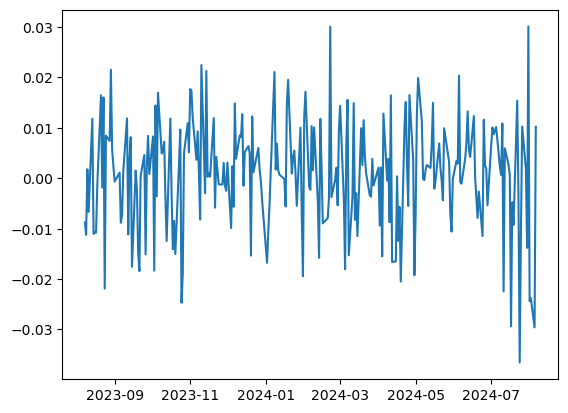

In [77]:
##Fetching the SP500 
M=fetch_stock_data("^NDX",period)
MRet=pd.DataFrame({"NDX":M.pct_change().iloc[1:]})
plt.plot(MRet)
MRet.index=Y1_PAR.index
## Market Factor (Market - RF)
MarketFarctor=MRet["NDX"]-Y1_PAR["Y1_PAR_D"]

In [78]:
import statsmodels.api as sm

Betas=pd.DataFrame()
Alphas=pd.DataFrame()

for i in SP500Ret: 
    y=SP500Ret[i]-Y1_PAR["Y1_PAR_D"]
    x=sm.add_constant(MarketFarctor)
    model = sm.OLS(y, x)
    results = model.fit()
    coefs = results.params
    Alphas[str(i)]=[coefs["const"]]
    Betas[str(i)]=[coefs[0]]

Betas=Betas.transpose()
Betas.columns=["Betas"]

Alphas=Alphas.transpose()
Alphas.columns=["Alphas"]

In [79]:
###Computing Yearly Volatilities and Tranforming them into daily 
Vol=[]
Vol_Y=[]
for i in SP500Ret:
    Vol_Y_I=np.std(SP500Ret[i])
    Vol_Y.append(Vol_Y_I)
    Vol.append(Vol_Y_I/np.sqrt(len(SP500Ret)))
    
Vol=pd.DataFrame({"Vol":Vol})
Vol.index=SP500Ret.columns

Vol_Y=pd.DataFrame({"Vol":Vol_Y})
Vol_Y.index=SP500Ret.columns

###Computing Yearly Volatilities and Tranforming them into daily 


In [80]:
###Computing Yearly Returns: 
Returns=[]
for i in SP500Ret:
    Returns.append(np.exp(sum(np.log(1+SP500Ret[i])))-1)

Returns=pd.DataFrame({"Returns":Returns})
Returns.index=SP500Ret.columns


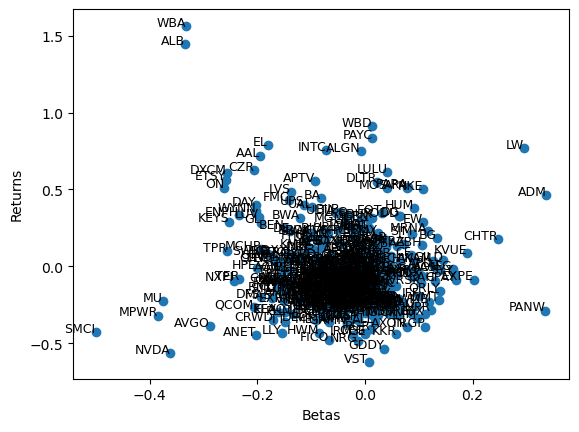

In [93]:
axx=plt.scatter(Betas["Betas"], Returns["Returns"])
plt.xlabel('Betas')
plt.ylabel('Returns')

for i in range(len(Betas)):
    plt.text(Betas["Betas"].iloc[i], Returns["Returns"].iloc[i],
             Betas.index.tolist()[i], fontsize=9, ha='right')

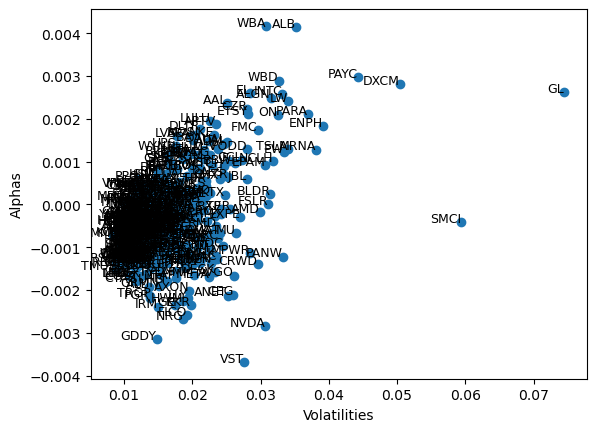

In [101]:
axx=plt.scatter(Vol_Y["Vol"], Alphas["Alphas"])
plt.xlabel('Volatilities')
plt.ylabel('Alphas')

for i in range(len(Alphas)):
    plt.text(Vol_Y["Vol"].iloc[i], Alphas["Alphas"].iloc[i],
             Vol_Y.index.tolist()[i], fontsize=9, ha='right')

In [98]:
Vol_Y

,Vol
AAPL,0.014187
MSFT,0.012620
NVDA,0.030680
GOOG,0.017554
GOOGL,0.017642
...,...
BBWI,0.026321
IVZ,0.020120
NCLH,0.031809
ETSY,0.028186
